In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from scipy.fft import fft
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
from datetime import datetime

In [19]:
url = "https://raw.githubusercontent.com/rahmantaufik27/dataset/main/study/forecasting_stock_price_2.csv"
df = pd.read_csv(url, parse_dates=['Timestamp'], index_col='Timestamp')

# Resample to daily data
df = df.resample('D').mean()  # can also use 'W' for weekly, 'H' for hourly, etc.

df

,Open Price,Close Price
Timestamp,,
2015-01-01,18713.336400,18713.525733
2015-01-02,19034.010000,19034.978800
2015-01-03,NaN,NaN
2015-01-04,NaN,NaN
2015-01-05,19064.982000,19064.700400
...,...,...
2020-12-20,NaN,NaN
2020-12-21,30199.557540,30196.556614
2020-12-22,29346.961243,29346.858995


In [20]:
df.describe()

,Open Price,Close Price
count,1481.000000,1481.000000
mean,23080.181973,23080.101875
std,4846.401238,4846.381211
min,1570.811156,1570.671505
25%,18757.372000,18756.699200
50%,23375.409814,23374.539257
75%,26904.367196,26904.072884
max,32411.172487,32410.467063


In [21]:
#  Check for missing values
print(" Missing values:")
print(df.isnull().sum())

 Missing values:
Open Price     704
Close Price    704
dtype: int64


In [24]:
df = df.dropna()
print(df.isnull().sum())

Open Price     0
Close Price    0
dtype: int64


In [25]:
# Check for duplicates
print(" Number of duplicates:", df.duplicated().sum())

 Number of duplicates: 0


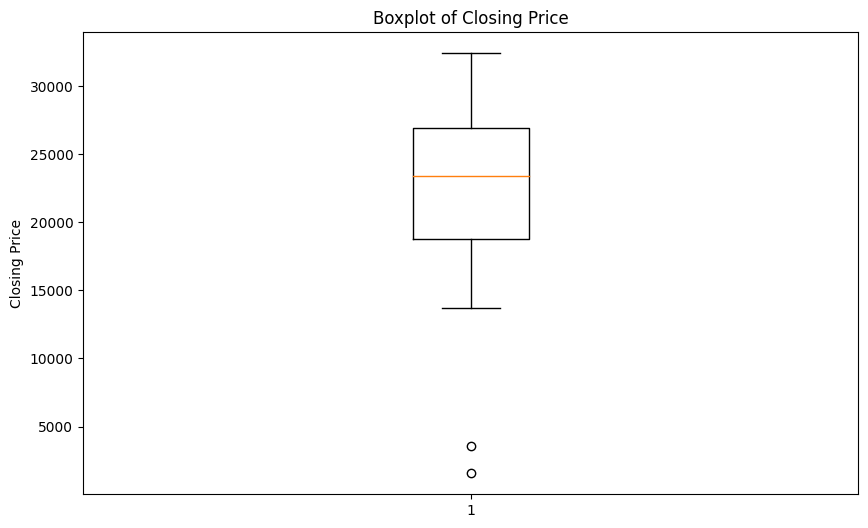

In [26]:
# Check for outliers
plt.figure(figsize=(10, 6))
plt.boxplot(df['Close Price'])
plt.title('Boxplot of Closing Price')
plt.ylabel('Closing Price')
plt.show()

In [30]:
#remove outliers
df = df[df['Close Price'] >= 10000]

 Data visualization (continued)


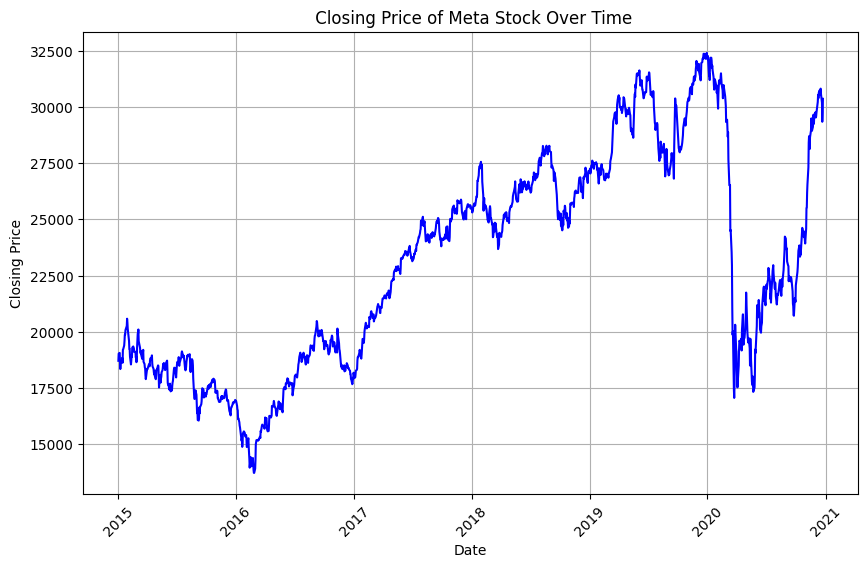

In [31]:
# Data visualization (continued)
print(" Data visualization (continued)")
# Plotting the closing price over time
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close Price'], color='blue')
plt.title(' Closing Price of Meta Stock Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

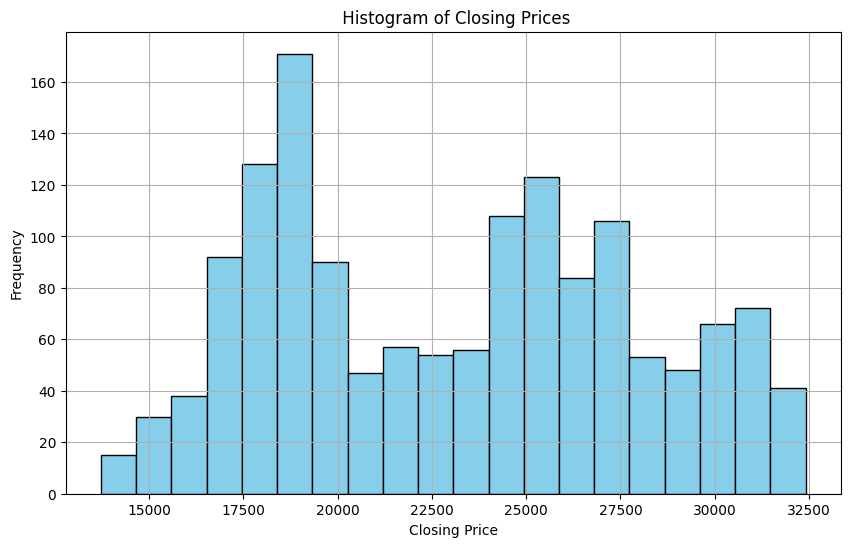

In [32]:
# Histogram of closing prices
plt.figure(figsize=(10, 6))
plt.hist(df['Close Price'], bins=20, color='skyblue', edgecolor='black')
plt.title(' Histogram of Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [34]:
# Daily returns
df['Daily_Return'] = df['Close Price'].pct_change() * 100
print(" Daily returns:")
print(df['Daily_Return'].head())

 Daily returns:
Timestamp
2015-01-01         NaN
2015-01-02    1.717758
2015-01-05    0.156142
2015-01-06   -2.243032
2015-01-07   -1.560010
Name: Daily_Return, dtype: float64


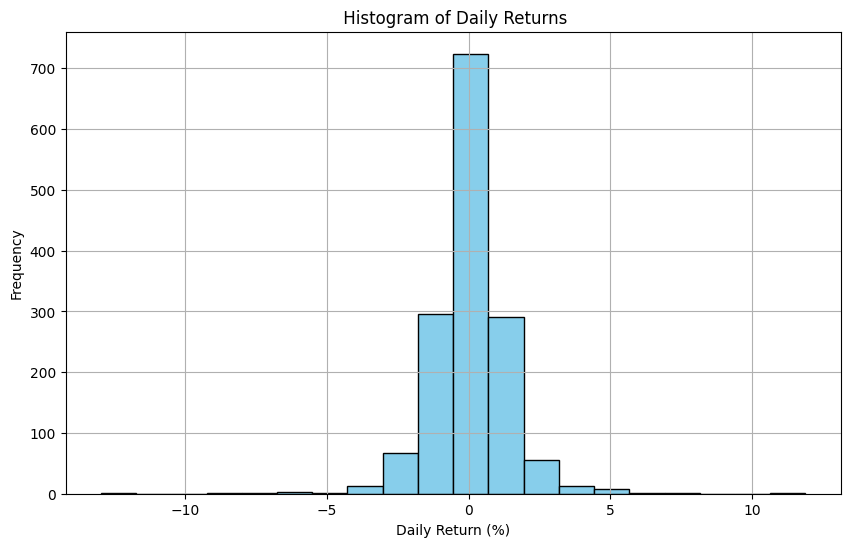

In [36]:
# Histogram of daily returns
plt.figure(figsize=(10, 6))
plt.hist(df['Daily_Return'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title(' Histogram of Daily Returns')
plt.xlabel('Daily Return (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

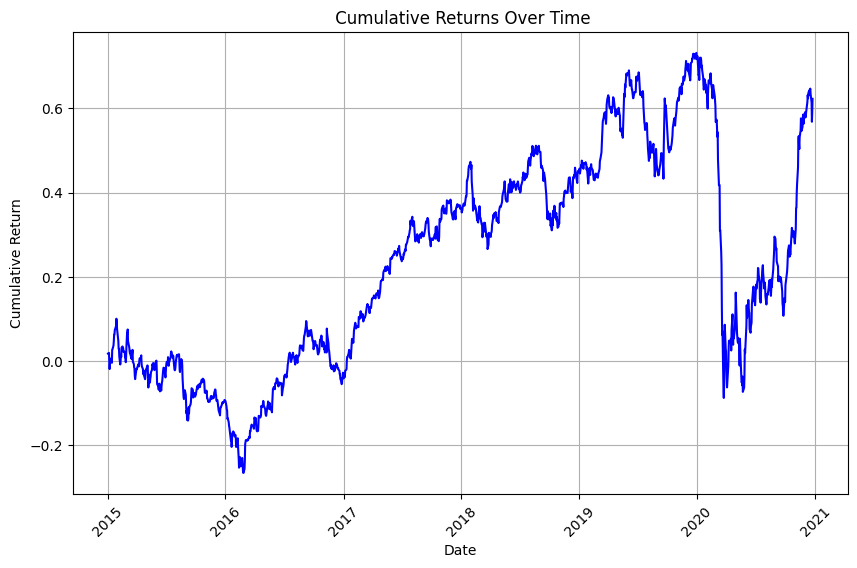

In [38]:
#  Cumulative returns
df['Cumulative_Return'] = (1 + df['Daily_Return'] / 100).cumprod() - 1
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Cumulative_Return'], color='blue')
plt.title(' Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

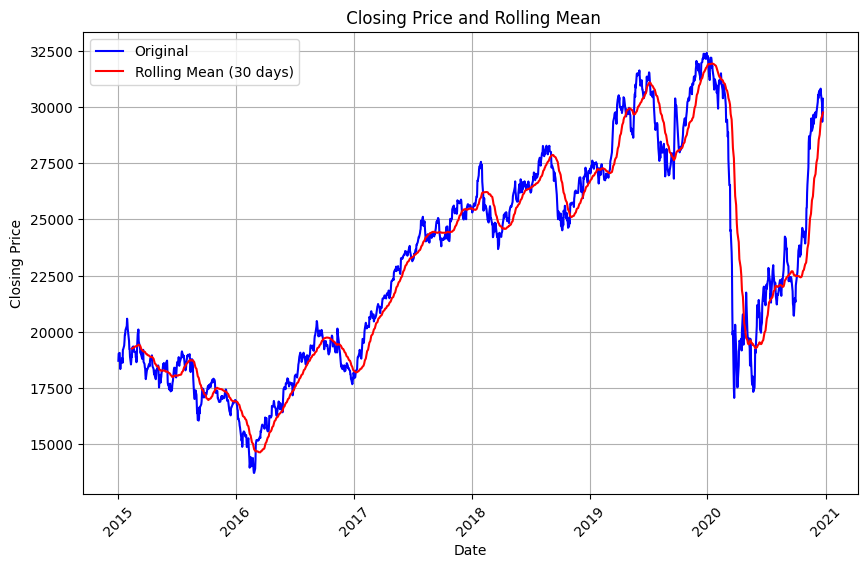

In [43]:
#  Rolling mean
window = 30  # Rolling window size
df['Rolling_Mean'] = df['Close Price'].rolling(window=window).mean()
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close Price'], label='Original', color='blue')
plt.plot(df.index, df['Rolling_Mean'], label=f'Rolling Mean ({window} days)', color='red')
plt.title(' Closing Price and Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

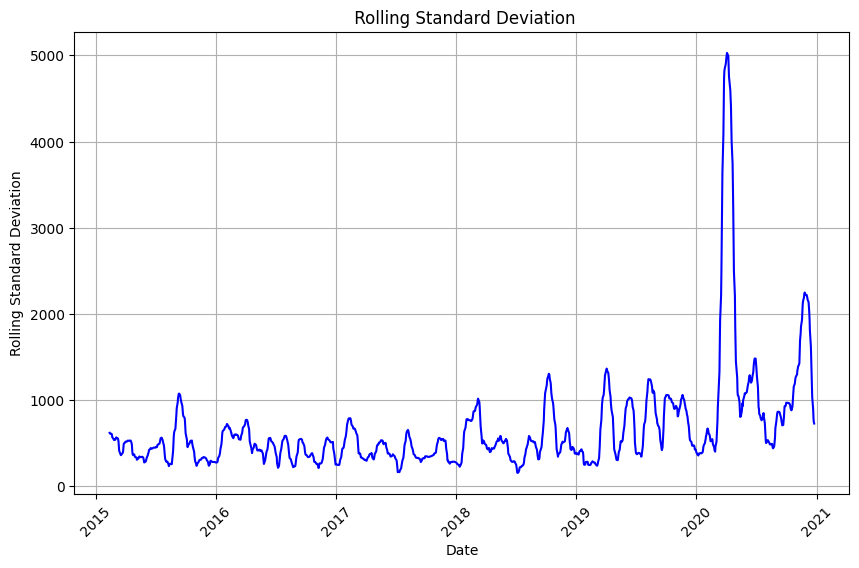

In [45]:
#  Rolling standard deviation
df['Rolling_Std'] = df['Close Price'].rolling(window=window).std()
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Rolling_Std'], color='blue')
plt.title(' Rolling Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Rolling Standard Deviation')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

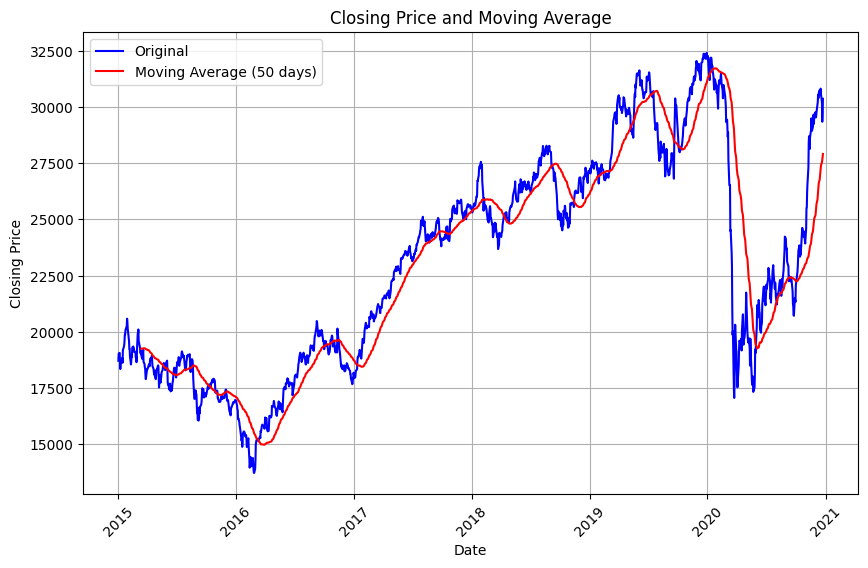

In [50]:
# Plotting moving average``
window = 50  # Moving average window size
df['Moving_Average'] = df['Close Price'].rolling(window=window).mean()
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close Price'], label='Original', color='blue')
plt.plot(df.index, df['Moving_Average'], label=f'Moving Average ({window} days)', color='red')
plt.title('Closing Price and Moving Average')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

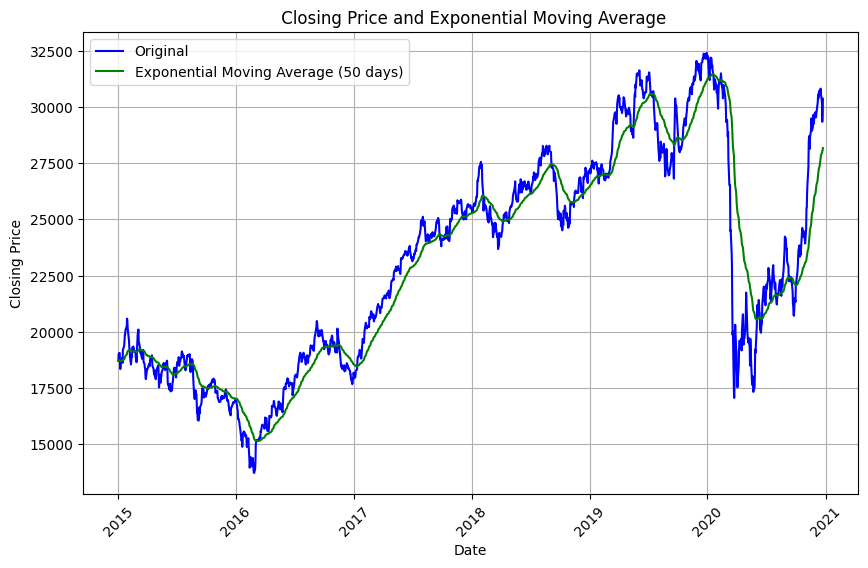

In [51]:
# Exponential moving average``
df['Exponential_Moving_Average'] = df['Close Price'].ewm(span=window, adjust=False).mean()
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close Price'], label='Original', color='blue')
plt.plot(df.index, df['Exponential_Moving_Average'], label=f'Exponential Moving Average ({window} days)', color='green')
plt.title(' Closing Price and Exponential Moving Average')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1000x800 with 0 Axes>

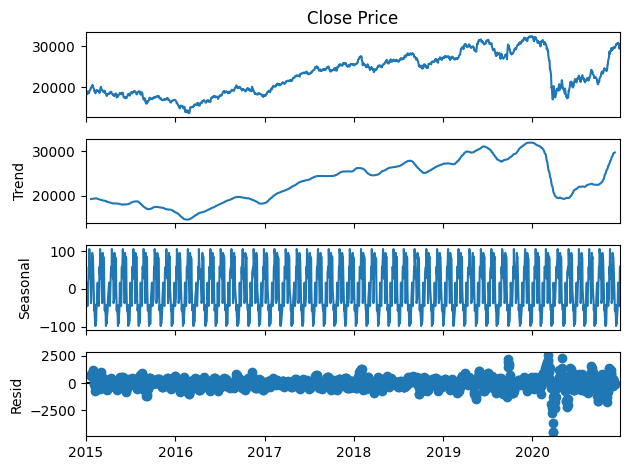

--------------------------------------------------


<Figure size 1000x800 with 0 Axes>

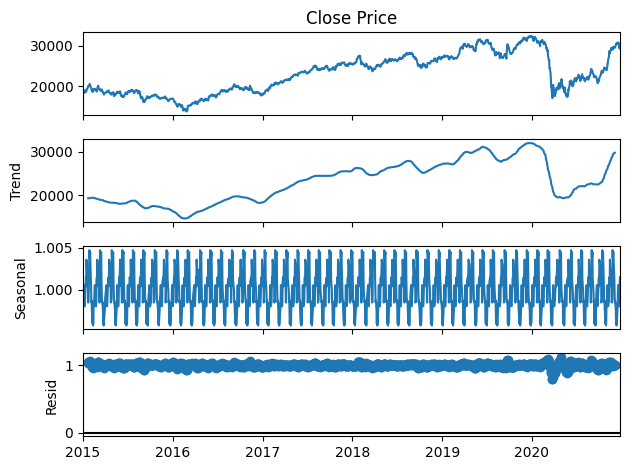

In [53]:
# Additive decomposition
result_additive = seasonal_decompose(df['Close Price'], model='additive', period=30)
plt.figure(figsize=(10, 8))
result_additive.plot()
#plt.suptitle( 'Additive Time Series Decomposition')
plt.show()
print("--------------------------------------------------")

# Multiplicative decomposition
result_multiplicative = seasonal_decompose(df['Close Price'], model='multiplicative', period=30)
plt.figure(figsize=(10, 8))
result_multiplicative.plot()
#plt.suptitle(' Multiplicative Time Series Decomposition')
plt.show()

<Figure size 1000x600 with 0 Axes>

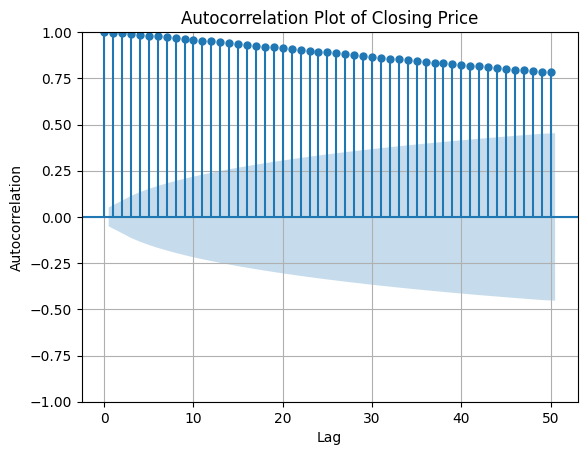

--------------------------------------------------


<Figure size 1000x600 with 0 Axes>

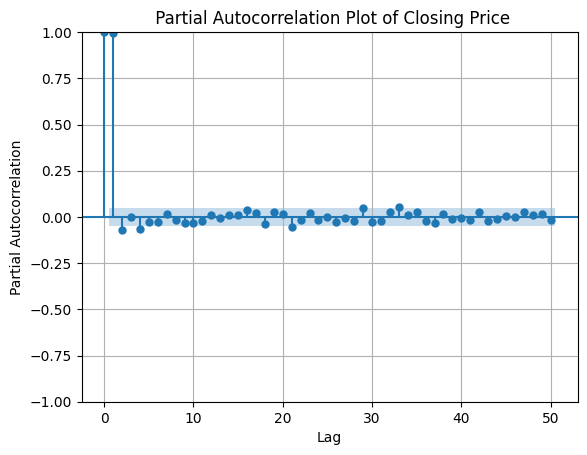

In [54]:
# Autocorrelation plot`
plt.figure(figsize=(10, 6))
plot_acf(df['Close Price'], lags=50)
plt.title('Autocorrelation Plot of Closing Price')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()
print("--------------------------------------------------")

#  Partial Autocorrelation plot
plt.figure(figsize=(10, 6))
plot_pacf(df['Close Price'], lags=50)
plt.title(' Partial Autocorrelation Plot of Closing Price')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

**ARIMA MODEL**

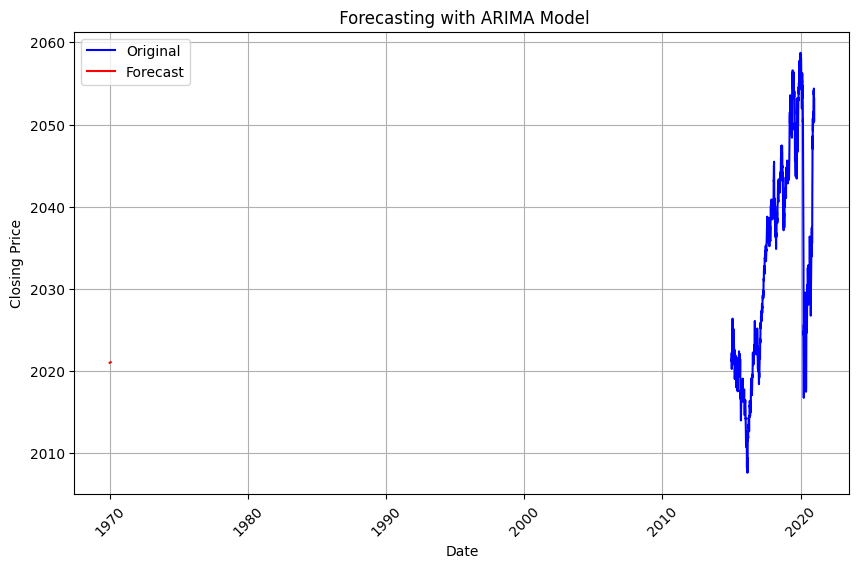

In [58]:
# Get the last date in the original dataset
last_date = df.index[-1]

# Create a range of dates for the forecasted period
forecast_dates = pd.date_range(start=last_date, periods=30, freq='D')

# Plotting the original data and forecast
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close Price'], label='Original', color='blue')
plt.plot(forecast_dates,  label='Forecast', color='red')  # Adjusted for forecast date
plt.title(' Forecasting with ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

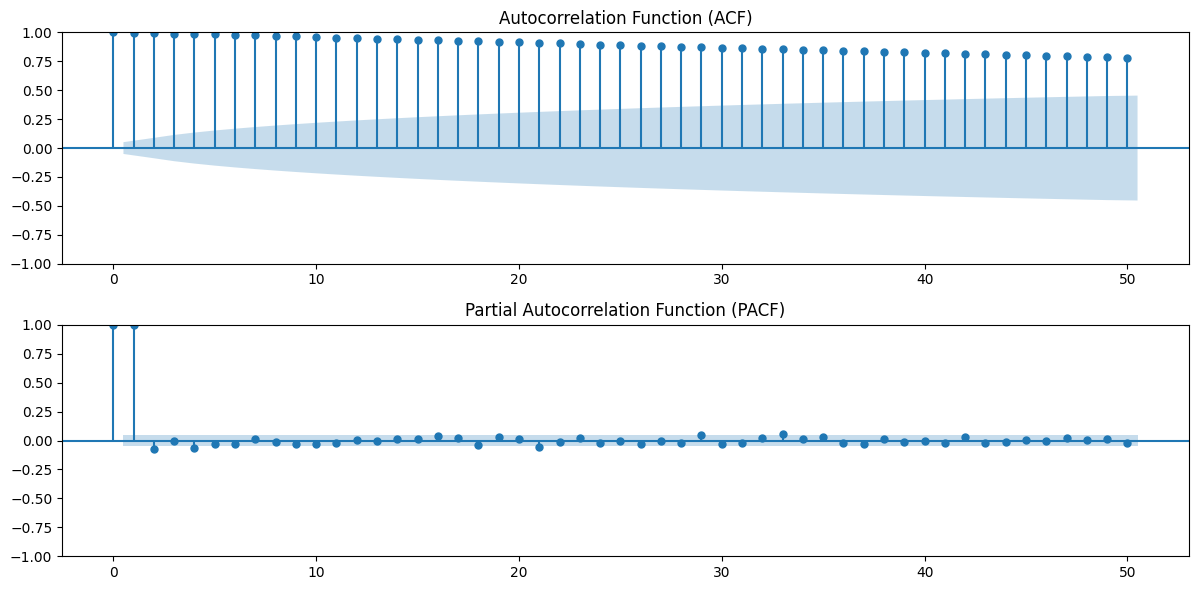

In [56]:
# 6.1: Plotting ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(df['Close Price'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.subplot(2, 1, 2)
plot_pacf(df['Close Price'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

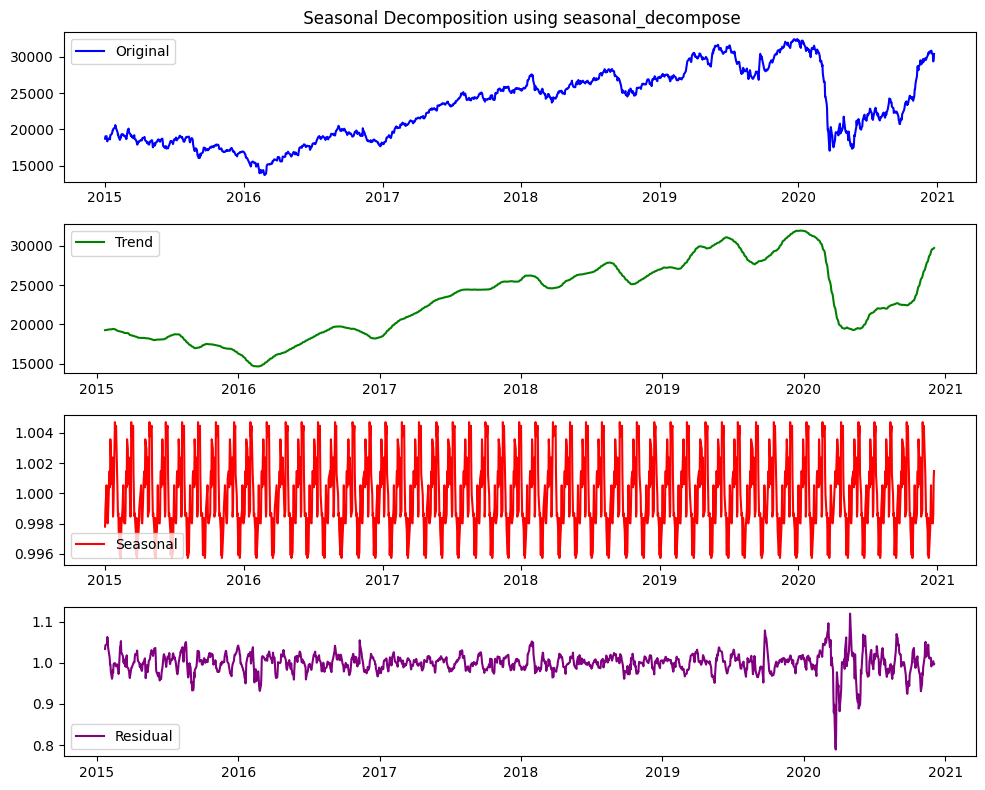

In [60]:
# 6.2 : Seasonal decomposition using seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(df['Close Price'], model='multiplicative', period=30)  # Adjust period if necessary

# Plot the decomposition
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(df.index, df['Close Price'], label='Original', color='blue')
plt.legend()
plt.title(' Seasonal Decomposition using seasonal_decompose')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal', color='red')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual', color='purple')
plt.legend()

plt.tight_layout()
plt.show()

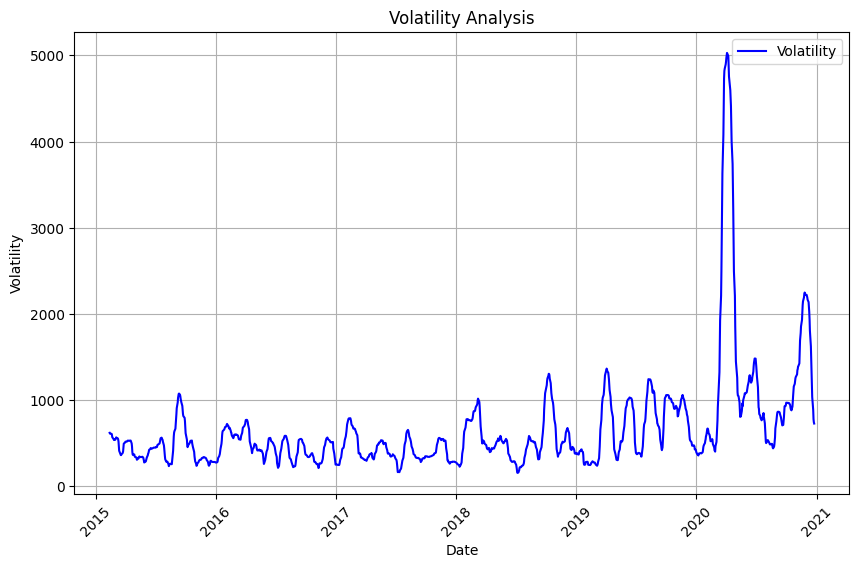

In [61]:
# 6.3 : Calculate and plot volatility (e.g., rolling standard deviation)
window = 30  # Define the window size
volatility = df['Close Price'].rolling(window=window).std()
plt.figure(figsize=(10, 6))
plt.plot(df.index, volatility, label='Volatility', color='blue')
plt.title('Volatility Analysis')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [62]:
# 6.4 : Augmented Dickey-Fuller (ADF) Test
result = adfuller(df['Close Price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -1.1357937652231618
p-value: 0.700588808477575
Critical Values:
   1%: -3.434785139702456
   5%: -2.863498825305098
   10%: -2.5678128583805213
